In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

In [4]:
## load and transform data
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='D:\TU_KL\CI_project/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='D:\TU_KL\CI_project/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def replace_pixels(inputs):
    for i,image in enumerate(inputs):
        img = image
        for j, k in itertools.product(range(len(img[0])), range(len(img[0]))):
            if k%2 == 0 and j%2 == 0:
                img[0][j][k] = 0.5
                img[1][j][k] = 0.5
                img[2][j][k] = 0.5

        inputs[i] = img
    return inputs

In [9]:
def replace_center(inputs):
    for i,image in enumerate(inputs):
        img = image
        for j, k in itertools.product(range(len(img[0])), range(len(img[0]))):
            if 8<=j<24 and 8<=k<24:
                img[0][j][k] = 0.5
                img[1][j][k] = 0.5
                img[2][j][k] = 0.5

        inputs[i] = img
    return inputs

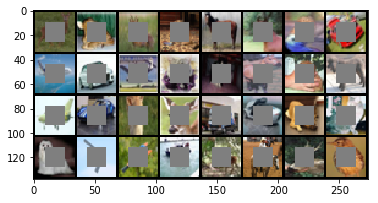

 deer  deer  deer   cat horse horse  bird   car plane   car plane   cat   cat horse   dog   dog plane   car  deer  deer truck   car   dog   cat   dog plane  bird  ship  deer horse  deer  bird


In [15]:
## this block is only for visualization of dataset, not necessary for training and evaluation

dataiter = iter(trainloader)
images, labels = dataiter.next()
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = replace_center(images)
#images = replace_pixels(images)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = resnet18(num_classes=10)

net.to(device)
    
## initialize loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=9e-1)

In [ ]:
train_flag = 2   #1=replace every other pixel, 2=replace center, any other number = default images

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if train_flag==1:
            inputs = replace_pixels(inputs)
        elif train_flag==2:
            inputs = replace_center(inputs)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
    print('[%d] loss: %.3f' % (epoch + 1, running_loss/i))
    running_loss = 0.0

print('Finished Training')

[1] loss: 2.041
[2] loss: 1.654
[3] loss: 1.510
[4] loss: 1.392


In [13]:
PATH = './cifar_net_rep_center.pth'
torch.save(net.state_dict(), PATH)

# Only test cells below

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_net = resnet18(num_classes=10)

test_net.to(device)

test_flag = 0   #0=default images, 1=replace every other pixel, 2=replace center

if test_flag == 0:
    test_path = './cifar_net.pth'
if test_flag == 1:
    test_path = './cifar_net_rep_pixels.pth'
elif test_flag == 2:
    test_path = './cifar_net_rep_center.pth'

    

test_net.load_state_dict(torch.load(test_path))

<All keys matched successfully>

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        if test_flag==1:
            images = replace_pixels(images)
        elif test_flag==2:
            images = replace_center(images)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

f = open("results.txt", "a")
for i in range(10):
    class_acc = 100 * class_correct[i] / class_total[i]
    print('Accuracy of %5s : %2d %%' % (classes[i], class_acc))
    f.write('Accuracy of %5s : %3d %% \n' % (classes[i],class_acc))
    
f.close()

Accuracy of plane : 74 %
Accuracy of   car : 83 %
Accuracy of  bird : 56 %
Accuracy of   cat : 57 %
Accuracy of  deer : 64 %
Accuracy of   dog : 69 %
Accuracy of  frog : 72 %
Accuracy of horse : 81 %
Accuracy of  ship : 83 %
Accuracy of truck : 77 %


produced by following the pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        if test_flag==1:
            images = replace_pixels(images)
        elif test_flag==2:
            images = replace_center(images)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))